In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt 
from sklearn.utils import shuffle
import random

# Initialize Data

In [2]:
def getName(filePath):
    return filePath.split('\\')[-1]

In [3]:
def importDataInfo(path):
    columns = ['Centre', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    print('Total images imported are: ', data.shape[0])
    #print(data.head())
    #print(data['Centre'][0])
    #print(getName(data['Centre'][0]))
    
    data['Centre'] = data['Centre'].apply(getName)
    #print(data.head())
    return data

In [4]:
path = 'SimulationData'
data = importDataInfo(path)
print(data.head())

Total images imported are:  6572
                               Centre  \
0  center_2022_10_16_18_42_00_492.jpg   
1  center_2022_10_16_18_42_00_585.jpg   
2  center_2022_10_16_18_42_00_678.jpg   
3  center_2022_10_16_18_42_00_772.jpg   
4  center_2022_10_16_18_42_00_867.jpg   

                                                Left  \
0  F:\Self driving Car\SimulationData\IMG\left_20...   
1  F:\Self driving Car\SimulationData\IMG\left_20...   
2  F:\Self driving Car\SimulationData\IMG\left_20...   
3  F:\Self driving Car\SimulationData\IMG\left_20...   
4  F:\Self driving Car\SimulationData\IMG\left_20...   

                                               Right  Steering  Throttle  \
0  F:\Self driving Car\SimulationData\IMG\right_2...       0.0       0.0   
1  F:\Self driving Car\SimulationData\IMG\right_2...       0.0       0.0   
2  F:\Self driving Car\SimulationData\IMG\right_2...       0.0       0.0   
3  F:\Self driving Car\SimulationData\IMG\right_2...       0.0       0.0   
4  

# Visualize and Balance Data

In [5]:
def balanceData(data, display=True):
    nBins = 31
    samplesPerBin = 350
    hist, bins = np.histogram(data['Steering'], nBins)
    #print(hist)
    #print(bins)
    if display:
        centre = (bins[:-1] + bins[1:])*0.5
        #print(centre)
        plt.bar(centre, hist, width = 0.06)
        plt.plot((-1,1), (samplesPerBin, samplesPerBin))
        plt.show()
        
    removeIndexList = []
    for j in range(nBins):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j+1]:
                binDataList.append(i)
                
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeIndexList.extend(binDataList)
        
    print('Removed Images:' ,len(removeIndexList))    
    data.drop(data.index[removeIndexList], inplace=True)
    print('Remaining Images:',len(data) )
    
    if display:
        hist, _ = np.histogram(data['Steering'], nBins)
        #print(centre)
        plt.bar(centre, hist, width = 0.06)
        plt.plot((-1,1), (samplesPerBin, samplesPerBin))
        plt.show()
        
    return data

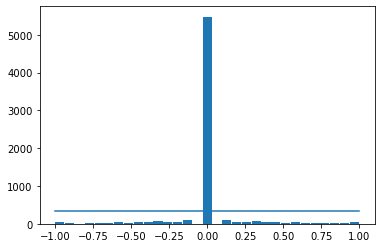

Removed Images: 5128
Remaining Images: 1444


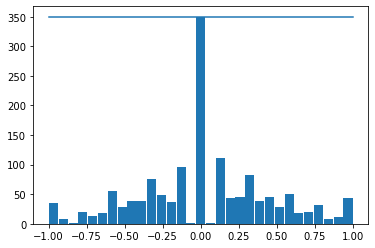

                                Centre  \
3   center_2022_10_16_18_42_00_772.jpg   
10  center_2022_10_16_18_42_01_431.jpg   
11  center_2022_10_16_18_42_01_524.jpg   
12  center_2022_10_16_18_42_01_619.jpg   
16  center_2022_10_16_18_42_01_993.jpg   

                                                 Left  \
3   F:\Self driving Car\SimulationData\IMG\left_20...   
10  F:\Self driving Car\SimulationData\IMG\left_20...   
11  F:\Self driving Car\SimulationData\IMG\left_20...   
12  F:\Self driving Car\SimulationData\IMG\left_20...   
16  F:\Self driving Car\SimulationData\IMG\left_20...   

                                                Right  Steering  Throttle  \
3   F:\Self driving Car\SimulationData\IMG\right_2...      0.00  0.000000   
10  F:\Self driving Car\SimulationData\IMG\right_2...     -0.10  0.155102   
11  F:\Self driving Car\SimulationData\IMG\right_2...     -0.35  0.000000   
12  F:\Self driving Car\SimulationData\IMG\right_2...     -0.60  0.000000   
16  F:\Self driving

In [6]:
data = balanceData(data, display=True)
print(data.head())

# Preparing for Processing

In [7]:
def loadData(path, data):
    imagesPath = []
    steering = []
    for i in range(len(data)):
        indexedData = data.iloc[i]
        imagesPath.append(os.path.join(path,'IMG',indexedData[0]))
        steering.append(float(indexedData[3]))
        
    imagesPath = np.asarray(imagesPath)
    steering = np.asarray(steering)
    
    return imagesPath, steering

In [8]:
imagesPath, steering = loadData(path, data)
print(imagesPath[0], steering[0])

SimulationData\IMG\center_2022_10_16_18_42_00_772.jpg 0.0


# Splitting of the dataset

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steering, test_size = 0.2, random_state = 10)
print('Total training Images:', len(xTrain))
print('Total validation Images:', len(xVal))

Total training Images: 1155
Total validation Images: 289


# Augmentation

In [14]:
import matplotlib.image as mpimg
import cv2
from imgaug import augmenters as iaa

In [16]:
def augmentImage(imagePath, steering):
    img = mpimg.imread(imagePath)
    
    ##PAN
    if(np.random.rand()<0.5):
        pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1, 0.1)})
        img = pan.augment_image(img)
    
    ##ZOOM
    if(np.random.rand()<0.5):
        zoom = iaa.Affine(scale=(1,1.2))
        img = zoom.augment_image(img)
    
    ##BRIGHTNESS
    if(np.random.rand()<0.5):
        brightness = iaa.Multiply((0.5,1.2))
        img = brightness.augment_image(img)
    
    ##FLIP
    if(np.random.rand()<0.5):
        img = cv2.flip(img, 1)
        steering = -steering
    
    return img, steering

# Preprocessing

In [18]:
def preprocessing(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    
    return img

In [19]:
def BatchGenerator(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []
        
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath)-1)
            
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preprocessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
            
        yield(np.asarray(imgBatch), np.asarray(steeringBatch))

# Creating the Model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [28]:
def createModel():
    model = Sequential()
    
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))
    
    model.compile(Adam(lr=0.0001),loss='mse')
    return model

In [29]:
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

C:\Users\guestuser\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training

In [31]:
history = model.fit(BatchGenerator(xTrain, yTrain, 100, 1), steps_per_epoch=300, epochs=10,
                                  validation_data=BatchGenerator(xVal, yVal, 100, 0), validation_steps=200)

Epoch 1/10
300/300 [==============================] - 214s 714ms/step - loss: 0.1297 - val_loss: 0.0897
Epoch 2/10
300/300 [==============================] - 213s 710ms/step - loss: 0.1142 - val_loss: 0.0834
Epoch 3/10
300/300 [==============================] - 212s 709ms/step - loss: 0.1034 - val_loss: 0.0787
Epoch 4/10
300/300 [==============================] - 218s 727ms/step - loss: 0.0941 - val_loss: 0.0780
Epoch 5/10
300/300 [==============================] - 216s 723ms/step - loss: 0.0888 - val_loss: 0.0776
Epoch 6/10
300/300 [==============================] - 216s 722ms/step - loss: 0.0861 - val_loss: 0.0718
Epoch 7/10
300/300 [==============================] - 215s 717ms/step - loss: 0.0836 - val_loss: 0.0732
Epoch 8/10
300/300 [==============================] - 214s 716ms/step - loss: 0.0803 - val_loss: 0.0685
Epoch 9/10
300/300 [==============================] - 213s 711ms/step - loss: 0.0795 - val_loss: 0.0713
Epoch 10/10
300/300 [==============================] - 216s 720m

# Saving and Plotting

Model Saved


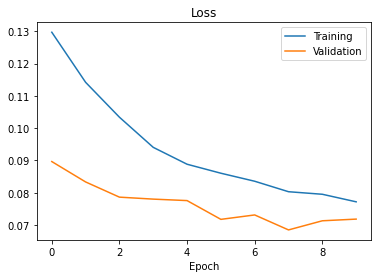

In [32]:
model.save('model.h5')
print('Model Saved')


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

# Testing

In [62]:
from sklearn.metrics import mean_squared_error

In [75]:
testPath = 'TestingData'
testData = importDataInfo(testPath)
testImagesPath, testSteering = loadData(path, data)
print(testImagesPath[0], testSteering[0])

Total images imported are:  1271
SimulationData\IMG\center_2022_10_16_18_42_00_772.jpg 0.0


In [69]:
def testModel(imagesPath):
    steering = []
    for index in range(len(imagesPath)):
        image = mpimg.imread(imagesPath[index])
        #image = np.asarray(image)
        image = preprocessing(image)
        image = np.array([image])
        steering.append(model.predict(image)[0][0])
        print(steering[index])
        
    return steering

In [76]:
results = testModel(testImagesPath)

1/1 [==============================] - 0s 26ms/step
-0.44971368
1/1 [==============================] - 0s 21ms/step
-0.44999108
1/1 [==============================] - 0s 26ms/step
-0.45905
1/1 [==============================] - 0s 28ms/step
-0.46554568
1/1 [==============================] - 0s 27ms/step
-0.45135155
1/1 [==============================] - 0s 26ms/step
-0.46392483
1/1 [==============================] - 0s 23ms/step
-0.45724037
1/1 [==============================] - 0s 25ms/step
-0.45938203
1/1 [==============================] - 0s 27ms/step
-0.4788778
1/1 [==============================] - 0s 30ms/step
-0.47148165
1/1 [==============================] - 0s 23ms/step
-0.44365048
1/1 [==============================] - 0s 30ms/step
-0.43520752
1/1 [==============================] - 0s 31ms/step
-0.51720095
1/1 [==============================] - 0s 29ms/step
-0.5748102
1/1 [==============================] - 0s 24ms/step
-0.47910398
1/1 [==============================] - 0s 27m

1/1 [==============================] - 0s 22ms/step
-0.13417171
1/1 [==============================] - 0s 24ms/step
-0.011592291
1/1 [==============================] - 0s 26ms/step
-0.1431523
1/1 [==============================] - 0s 29ms/step
0.18180525
1/1 [==============================] - 0s 28ms/step
0.061613884
1/1 [==============================] - 0s 21ms/step
-0.19802652
1/1 [==============================] - 0s 29ms/step
-0.16039602
1/1 [==============================] - 0s 28ms/step
-0.4900011
1/1 [==============================] - 0s 29ms/step
-0.34884694
1/1 [==============================] - 0s 23ms/step
-0.31371513
1/1 [==============================] - 0s 26ms/step
-0.36133164
1/1 [==============================] - 0s 22ms/step
-0.33411428
1/1 [==============================] - 0s 28ms/step
-0.3525964
1/1 [==============================] - 0s 28ms/step
-0.3558957
1/1 [==============================] - 0s 24ms/step
-0.3639839
1/1 [==============================] - 0s 27m

1/1 [==============================] - 0s 28ms/step
0.028444024
1/1 [==============================] - 0s 29ms/step
-0.35271853
1/1 [==============================] - 0s 26ms/step
-0.35841784
1/1 [==============================] - 0s 29ms/step
-0.3480263
1/1 [==============================] - 0s 25ms/step
-0.33133587
1/1 [==============================] - 0s 23ms/step
-0.34273896
1/1 [==============================] - 0s 24ms/step
-0.39537716
1/1 [==============================] - 0s 29ms/step
-0.36332655
1/1 [==============================] - 0s 28ms/step
-0.4499664
1/1 [==============================] - 0s 24ms/step
-0.4556211
1/1 [==============================] - 0s 29ms/step
-0.4542744
1/1 [==============================] - 0s 24ms/step
-0.4519435
1/1 [==============================] - 0s 22ms/step
-0.38453686
1/1 [==============================] - 0s 22ms/step
-0.3176287
1/1 [==============================] - 0s 22ms/step
-0.34058034
1/1 [==============================] - 0s 29ms

1/1 [==============================] - 0s 29ms/step
0.15937465
1/1 [==============================] - 0s 27ms/step
0.02486191
1/1 [==============================] - 0s 28ms/step
0.2731591
1/1 [==============================] - 0s 28ms/step
0.308273
1/1 [==============================] - 0s 28ms/step
0.36301365
1/1 [==============================] - 0s 24ms/step
0.3562169
1/1 [==============================] - 0s 27ms/step
0.40539187
1/1 [==============================] - 0s 22ms/step
0.4182339
1/1 [==============================] - 0s 28ms/step
0.41907305
1/1 [==============================] - 0s 23ms/step
0.45699027
1/1 [==============================] - 0s 26ms/step
0.43675417
1/1 [==============================] - 0s 28ms/step
0.43308887
1/1 [==============================] - 0s 28ms/step
0.42636877
1/1 [==============================] - 0s 26ms/step
0.12863645
1/1 [==============================] - 0s 25ms/step
0.32532635
1/1 [==============================] - 0s 27ms/step
0.314990

1/1 [==============================] - 0s 29ms/step
0.17304803
1/1 [==============================] - 0s 29ms/step
0.25731835
1/1 [==============================] - 0s 25ms/step
0.2977432
1/1 [==============================] - 0s 24ms/step
0.3236188
1/1 [==============================] - 0s 24ms/step
0.2085956
1/1 [==============================] - 0s 23ms/step
0.22853401
1/1 [==============================] - 0s 31ms/step
0.2668453
1/1 [==============================] - 0s 23ms/step
0.2653186
1/1 [==============================] - 0s 26ms/step
0.009388863
1/1 [==============================] - 0s 27ms/step
0.15219767
1/1 [==============================] - 0s 24ms/step
0.22479656
1/1 [==============================] - 0s 24ms/step
0.25525185
1/1 [==============================] - 0s 25ms/step
0.10596772
1/1 [==============================] - 0s 26ms/step
0.21512042
1/1 [==============================] - 0s 30ms/step
0.19460465
1/1 [==============================] - 0s 25ms/step
0.02980

1/1 [==============================] - 0s 29ms/step
0.24537836
1/1 [==============================] - 0s 30ms/step
0.31924334
1/1 [==============================] - 0s 29ms/step
0.34890872
1/1 [==============================] - 0s 28ms/step
0.22571859
1/1 [==============================] - 0s 30ms/step
0.26847726
1/1 [==============================] - 0s 29ms/step
0.18315347
1/1 [==============================] - 0s 24ms/step
0.2904405
1/1 [==============================] - 0s 24ms/step
0.28033367
1/1 [==============================] - 0s 31ms/step
0.32922453
1/1 [==============================] - 0s 30ms/step
0.34783104
1/1 [==============================] - 0s 27ms/step
0.31718537
1/1 [==============================] - 0s 25ms/step
0.26287946
1/1 [==============================] - 0s 23ms/step
0.28503424
1/1 [==============================] - 0s 29ms/step
0.28924012
1/1 [==============================] - 0s 26ms/step
0.2715769
1/1 [==============================] - 0s 31ms/step
0.103

In [77]:
results = np.asarray(results)

In [78]:
import math
MSE = mean_squared_error(testSteering, results) 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.243624092737182


In [79]:
results

array([-0.44971368, -0.44999108, -0.45905   , ...,  0.49985668,
        0.4295808 ,  0.3603437 ], dtype=float32)

In [80]:
testSteering

array([ 0.  , -0.1 , -0.35, ...,  1.  ,  0.15,  0.35])